Loads data from the dataset and applies transformntions


In [4]:

import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

batch_size = 32

def load_data():

    data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    }

    train_set = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=data_transforms['training'])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    test_set = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=data_transforms['testing'])
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    val_set = torchvision.datasets.Flowers102(root='./data', split="val", download=True, transform=data_transforms['validation'])
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)                                        
    
    return train_set, test_set, val_set, test_loader, train_loader, val_loader

train_set, test_set, val_set, test_loader, train_loader, val_loader = load_data()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


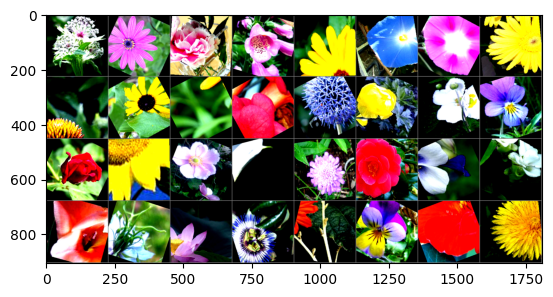

tensor(37)
tensor(65)
tensor(30)
tensor(93)
tensor(4)
tensor(75)
tensor(75)
tensor(40)
tensor(16)
tensor(62)
tensor(45)
tensor(100)
tensor(9)
tensor(15)
tensor(61)
tensor(51)
tensor(73)
tensor(53)
tensor(61)
tensor(19)
tensor(21)
tensor(95)
tensor(83)
tensor(38)
tensor(42)
tensor(32)
tensor(77)
tensor(76)
tensor(58)
tensor(51)
tensor(88)
tensor(49)


In [5]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
for i in range(batch_size):
  print(labels[i])

In [18]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5) 
        self.bn2 = nn.BatchNorm2d(32)

        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(32 * 53 * 53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=89888, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=102, bias=True)
)


In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [9]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
from torch.autograd import Variable

def train(epoch_num, model):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    overallIdeal = model
    testIdeal = model
    valIdeal = model
    min_running_loss = 100.0
    min_val_loss = 100.0

    trainingEpoch_loss = []
    validationEpoch_loss = []

    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        model.train()
        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            images = images.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            

        valid_loss = 0.0
        model.eval()
        for i, (images, labels) in enumerate(val_loader, 0):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            vloss = criterion(outputs, labels)
            valid_loss = vloss.item()*images.size(0)

        print(f'Epoch {epoch+1} \t\t Training Loss: {running_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        print("lr: ", get_lr(optimizer))

        trainingEpoch_loss.append(running_loss / len(train_loader))
        validationEpoch_loss.append(valid_loss / len(val_loader))
        #accuracy = testAccuracy(model)
        #print("\nepoch: ",epoch,"/",epoch_num," ... Loss: ",loss.item())
        #print('EPOCH:', epoch,'---> TEST ACCURACY: %d %%' % (accuracy))

        # validation dat

        #print("\nepoch: ",epoch,"/",epoch_num," ... Loss: ",loss.item()," VLoss: ", vloss.item())

        scheduler.step(running_loss)

        if running_loss < min_running_loss and valid_loss <= min_val_loss:
            min_running_loss = running_loss
            min_val_loss = valid_loss
            overallIdeal = model
        if running_loss < min_running_loss:
            min_running_loss = running_loss
            testIdeal = model
        elif valid_loss < min_val_loss:
            min_val_loss = valid_loss
            valIdeal = model


    # whatever you are timing goes here
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()
    print(start.elapsed_time(end))  # milliseconds

    return overallIdeal, valIdeal, testIdeal, trainingEpoch_loss, validationEpoch_loss



In [11]:
def test(data, model):
    correct = 0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    with torch.no_grad():
        for value in data:
            images, labels = value
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [16]:
def plotLoss(trainingLoss, valLoss):
    from matplotlib import pyplot as plt
    plt.plot(trainingLoss, label='train_loss')
    plt.plot(valLoss,label='val_loss')
    plt.legend()
    plt.show

In [20]:
if __name__ == "__main__":
    torch.cuda.empty_cache()
    
    # train the model with epoch number, model
    ideal, valIdeal, testIdeal, trainingLoss, valLoss = train(20, net)
    print('Finished Training')

    # Accuracy on training data
    #test(train_loader, net)
    #print("--------------")
    # Accuracy on valid data
    #test(val_loader, net)
    #print("--------------") 
    # Accuracy on test data
    #test(test_loader, net)
    

The model will be running on cuda:0 device
Epoch 1 		 Training Loss: 4.641435548663139 		 Validation Loss: 4.009567320346832
lr:  0.01
Epoch 2 		 Training Loss: 4.391582652926445 		 Validation Loss: 3.8201704621315002
lr:  0.01
Epoch 3 		 Training Loss: 4.208829492330551 		 Validation Loss: 3.0905098617076874
lr:  0.01
Epoch 4 		 Training Loss: 4.015707328915596 		 Validation Loss: 3.34219953417778
lr:  0.01
Epoch 5 		 Training Loss: 3.950728341937065 		 Validation Loss: 3.1382229030132294
lr:  0.01
Epoch 6 		 Training Loss: 3.765538588166237 		 Validation Loss: 3.1463272273540497
lr:  0.01
Epoch 7 		 Training Loss: 3.8102936819195747 		 Validation Loss: 3.4314025938510895
lr:  0.01
Epoch 8 		 Training Loss: 3.7358727529644966 		 Validation Loss: 3.072298288345337
lr:  0.01
Epoch 9 		 Training Loss: 3.6559543311595917 		 Validation Loss: 3.219200849533081
lr:  0.01
Epoch 10 		 Training Loss: 3.550128161907196 		 Validation Loss: 3.138191193342209
lr:  0.01
Epoch 11 		 Training Loss: 3.

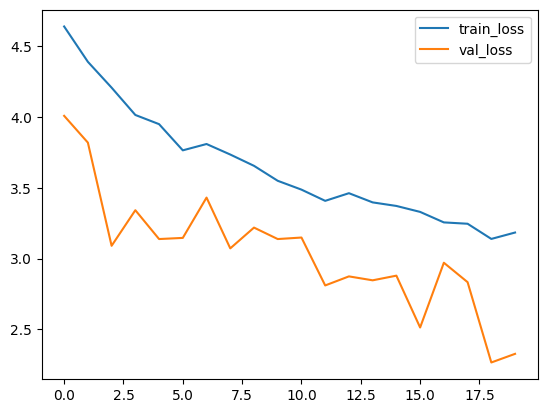

In [21]:
# plot the training loss and validation loss over all epochs
plotLoss(trainingLoss, valLoss)

In [22]:
# print accuracy on all sets

# Accuracy on training data
print("Training on final: ")
test(train_loader, net)
print("Training on ideal: ")
test(train_loader, ideal)
print("Training on testIdeal: ")
test(train_loader, testIdeal)
#test(train_loader, ideal)
print("--------------")
# Accuracy on valid data
print("Valid on final: ")
test(val_loader, net)
print("Valid on ideal: ")
test(val_loader, ideal)
print("Valid on valIdeal: ")
test(val_loader, valIdeal)
#test(val_loader, ideal)
print("--------------") 
# Accuracy on test data
print("Test on final: ")
test(test_loader, net)
print("Test on testIdeal: ")
test(test_loader, testIdeal)
print("Test on valIdeal: ")
test(test_loader, valIdeal)
print("Test on ideal: ")
test(test_loader, ideal)
#test(test_loader, ideal)

Training on final: 
Accuracy of the network on the 10000 test images: 22 %
Training on ideal: 
Accuracy of the network on the 10000 test images: 21 %
Training on testIdeal: 
Accuracy of the network on the 10000 test images: 21 %
--------------
Valid on final: 
Accuracy of the network on the 10000 test images: 19 %
Valid on ideal: 
Accuracy of the network on the 10000 test images: 19 %
Valid on valIdeal: 
Accuracy of the network on the 10000 test images: 19 %
--------------
Test on final: 
Accuracy of the network on the 10000 test images: 16 %
Test on testIdeal: 
Accuracy of the network on the 10000 test images: 16 %
Test on valIdeal: 
Accuracy of the network on the 10000 test images: 16 %
Test on ideal: 


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


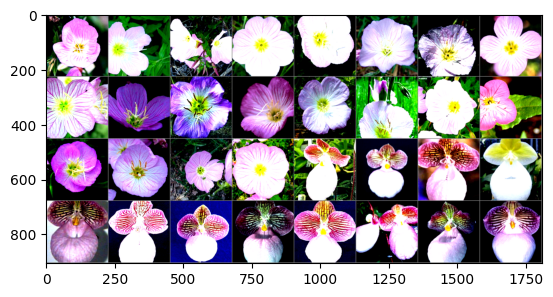

GroundTruth: 
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


In [19]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ')
for i in range(32):
  print(labels[i])

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)

for i in range(32):
  print(predicted[i])


tensor(33, device='cuda:0')
tensor(0, device='cuda:0')
tensor(21, device='cuda:0')
tensor(0, device='cuda:0')
tensor(68, device='cuda:0')
tensor(0, device='cuda:0')
tensor(33, device='cuda:0')
tensor(0, device='cuda:0')
tensor(67, device='cuda:0')
tensor(95, device='cuda:0')
tensor(8, device='cuda:0')
tensor(44, device='cuda:0')
tensor(0, device='cuda:0')
tensor(75, device='cuda:0')
tensor(0, device='cuda:0')
tensor(98, device='cuda:0')
tensor(51, device='cuda:0')
tensor(0, device='cuda:0')
tensor(77, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(67, device='cuda:0')
tensor(1, device='cuda:0')
tensor(12, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


In [ ]:
correct = 0
total = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

The model will be running on cuda:0 device
Accuracy of the network on the 10000 test images: 31 %
